In [1]:
%%capture 
%run config.ipynb

In [53]:
from dataclasses import dataclass
import numpy as np
from xml.etree import ElementTree
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
from pprint import pprint
from PIL import Image
import io
from pprint import pprint

In [3]:
# Define Ink class
@dataclass
class Ink:
    """Represents a single ink, as read from an InkML file."""
    # Every stroke in the ink.
    # Each stroke array has shape (3, number of points), where the first
    # dimensions are (x, y, timestamp), in that order.
    
    strokes: list[np.ndarray]
    # Metadata present in the InkML.
    annotations: dict[str, str]

    min_x: int
    min_y: int
    max_x: int
    max_y: int
    min_t: int
    max_t: int

    max_delta_x: int
    max_delta_y: int
    

In [4]:
# Define function that reads inkml file, and outputs Ink object
def read_inkml_file(filename: str) -> Ink:
    """Simple reader for MathWriting's InkML files."""
    with open(filename, "r") as f:
        root = ElementTree.fromstring(f.read())
        
        strokes = []
        annotations = {}
    
        max_x, max_y, max_t, min_x, min_y, min_t = None, None, None, None, None, None
    
        max_delta_x, max_delta_y = 0, 0
        
        for element in root:
            tag_name = element.tag.removeprefix('{http://www.w3.org/2003/InkML}')
            if tag_name == 'annotation':
                annotations[element.attrib.get('type')] = element.text
            
            elif tag_name == 'trace':
                points = element.text.split(',')
                stroke_x, stroke_y, stroke_t = [], [], []
                
                prev_x, prev_y = None, None
                for point in points:
                    x, y, t = [float(p) for p in point.split(' ')]
                    stroke_x.append(x)
                    stroke_y.append(y)
                    stroke_t.append(t)
    
                    if prev_x == None:
                        prev_x = x 
                        prev_y = y
        
                    if max_x == None:
                        max_x = x 
                        min_x = x 
                        max_y = y 
                        min_y = y 
                        max_t = t 
                        min_t = t
                    if x > max_x:
                        max_x = x 
                    if x < min_x:
                        min_x = x 
                    if y > max_y:
                        max_y = y 
                    if y < min_y:
                        min_y = y
                    if t > max_t:
                        max_t = t 
                    if t < min_t:
                        min_t = t
                    if abs(x - prev_x) > max_delta_x:
                        max_delta_x = abs(x - prev_x)
                    if abs(y - prev_y) > max_delta_y:
                        max_delta_y = abs(y - prev_y)
        
                    prev_x = x 
                    prev_y = y
                strokes.append(np.array((stroke_x, stroke_y, stroke_t)))

    return Ink(strokes=strokes, 
             annotations=annotations, 
             max_x=max_x, 
             min_x=min_x, 
             max_y=max_y,
             min_y=min_y,
             max_t=max_t,
             min_t=min_t,
             max_delta_x=max_delta_x,
             max_delta_y=max_delta_y)

In [5]:
# display inkml file into image
def display_ink(
    ink: Ink,
    *,
    figsize: tuple[int, int]=(15, 10),
    linewidth: int=2,
    color=None):
  """Simple display for a single ink."""
  plt.figure(figsize=figsize)
  for stroke in ink.strokes:
    plt.plot(stroke[0], stroke[1], linewidth=linewidth, color=color)
    plt.title(
        f"{ink.annotations.get('sampleId', '')} -- "
        f"{ink.annotations.get('splitTagOriginal', '')} -- "
        f"{ink.annotations.get('normalizedLabel', ink.annotations['label'])}"
    )
  plt.gca().invert_yaxis()
  plt.gca().axis('equal')

{'inkCreationMethod': 'human',
 'label': '|S| \\le \\binom{n}{\\lfloor n/2\\rfloor}',
 'normalizedLabel': '|S|\\le(\\begin{matrix}n\\\\ \\lfloor '
                    'n/2\\rfloor\\end{matrix})',
 'sampleId': '01fdfab60060594b',
 'splitTagOriginal': 'train'}


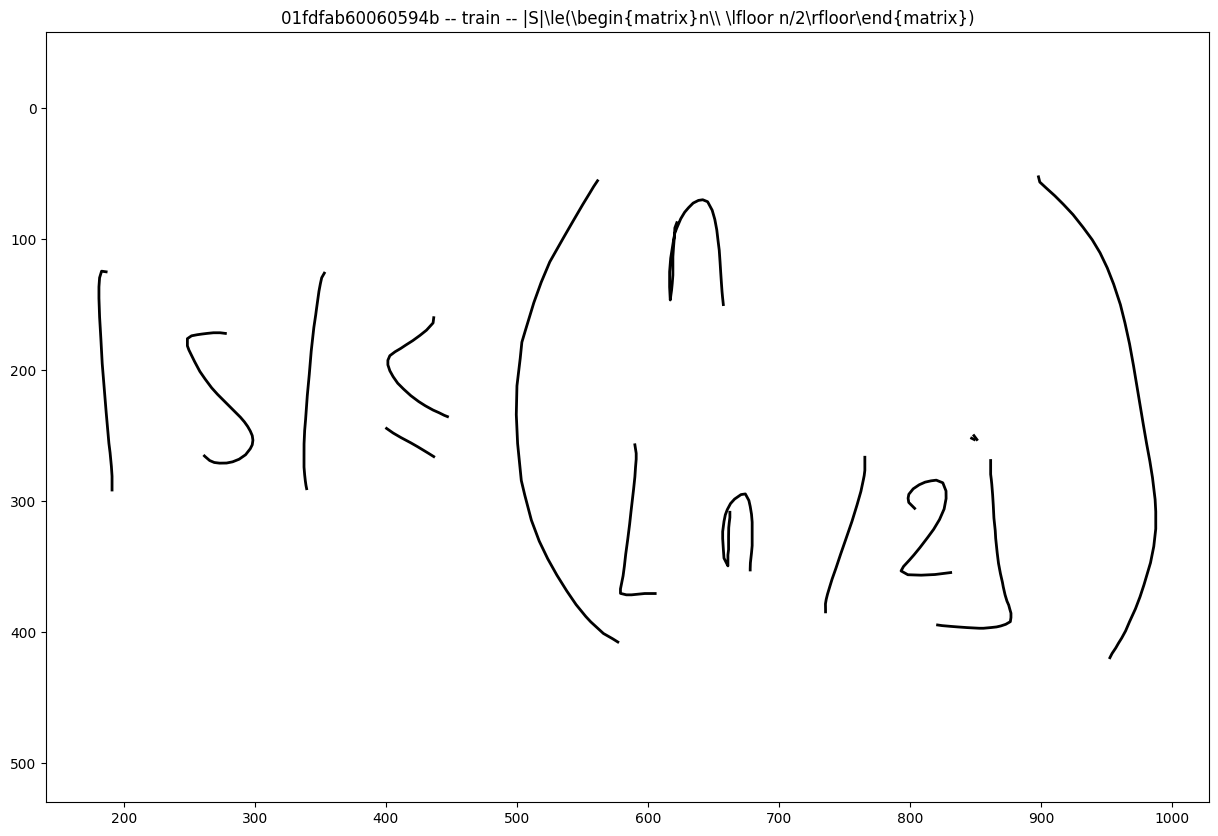

In [6]:
# TEST PURPOSE
test_inkml_file_path = data_dir / "mathwriting-2024-excerpt" / "train" / "01fdfab60060594b.inkml"
test_ink = read_inkml_file(test_inkml_file_path)
pprint(test_ink.annotations)
# pprint(test_ink.strokes)
display_ink(test_ink, color='black')


In [7]:
def get_ink_sequence_token(ink: Ink, timedelta_: int):
    """
    Apply 
    1. Time sampling
    2. Scale normalization
    3. Coordinate representation
    """

    # Time sampling
    time_sampled_strokes = []
    
    # time delta between two adjacent points should be at least timedelta_
    for stroke in ink.strokes: 
        stroke_x, stroke_y, stroke_t = stroke[0], stroke[1], stroke[2]

        prev_t = stroke_t[0] - (float(timedelta_) * 2)
        sampled_stroke_x, sampled_stroke_y= [], []
        
        for x, y, t in zip(stroke_x, stroke_y, stroke_t):

                
            if t - prev_t >= timedelta_:
                prev_t = t 
                # add this point to strokes 
                sampled_stroke_x.append(x)
                sampled_stroke_y.append(y)
                
        time_sampled_strokes.append(np.array((sampled_stroke_x, sampled_stroke_y)))

    # Scale normalization
    scale_normalized_strokes = []
    
    # print(f'max_x: {max_x}, min_x: {min_x}, max_y: {max_y}, min_y: {min_y}')

    # for every point's x value, (x - min_x) * (IMG_SIZE - 2 * PADDING) / (max_x - min_x) + PADDING
    # for every point's y value, (y - min_y) * IMG_SIZE / (max_y - min_y)
    for stroke in time_sampled_strokes:
        stroke_x, stroke_y = stroke[0], stroke[1]

        normalized_stroke_x, normalized_stroke_y = [], []
        for x, y in zip(stroke_x, stroke_y):
            normalized_stroke_x.append(((x - ink.min_x) * (IMG_SIZE - 2 * PADDING) / (ink.max_x - ink.min_x)) + PADDING)
            normalized_stroke_y.append(((y - ink.min_y) * (IMG_SIZE - 2 * PADDING) / (ink.max_y - ink.min_y)) + PADDING)

        scale_normalized_strokes.append(np.array((normalized_stroke_x, normalized_stroke_y)))

    # pprint(scale_normalized_strokes)

    # Discretization
    # Converting all float coordinates into int 
    discretized_strokes = []

    for stroke in scale_normalized_strokes:
        stroke_x, stroke_y = stroke[0], stroke[1]

        discretized_stroke_x, discretized_stroke_y = [], []

        for x, y in zip(stroke_x, stroke_y):
            discretized_stroke_x.append(round(x))
            discretized_stroke_y.append(round(y))
            
        discretized_strokes.append(np.array((discretized_stroke_x, discretized_stroke_y)))

    # pprint(discretized_strokes)

    # Coordinate representation
    relative_position_strokes = []

    for stroke in discretized_strokes:
        stroke_x, stroke_y = stroke[0], stroke[1]

        relative_stroke_x, relative_stroke_y = [], []

        prev_x, prev_y = None, None

        for x, y in zip(stroke_x, stroke_y):
            if prev_x == None and prev_y == None:
                relative_stroke_x.append(x)
                relative_stroke_y.append(y)
                prev_x = x 
                prev_y = y 
            else:
                relative_stroke_x.append(x - prev_x)
                relative_stroke_y.append(y - prev_y)
        
        relative_position_strokes.append(np.array((relative_stroke_x, relative_stroke_y)))
    # pprint(relative_position_strokes)

    # return string of sequences of points 
    # new stroke starts with seperator <stroke>
    result = ""
    for stroke in relative_position_strokes:
        stroke_x, stroke_y = stroke[0], stroke[1]
        result += "<stroke> "

        for x, y in zip(stroke_x, stroke_y):
            result += f'{x} {y} '

    # pprint(result)
    return result
    

In [8]:
# TEST PURPOSE
test_inkml_file_path = data_dir / "mathwriting-2024-excerpt" / "train" / "01fdfab60060594b.inkml"
test_ink = read_inkml_file(test_inkml_file_path)
get_ink_sequence_token(test_ink, TIME_SAMPLING_DELTA)

'<stroke> 6 53 -1 0 -2 3 -2 14 -2 29 -1 47 0 70 0 88 1 100 1 108 1 113 <stroke> 34 85 -2 -1 -3 -1 -6 0 -8 1 -9 2 -9 6 -8 14 -5 23 -2 31 1 37 3 43 5 48 6 52 6 57 4 62 1 66 -2 67 -4 65 -5 63 <stroke> 57 54 -1 2 -1 9 -2 21 -3 40 -4 59 -5 75 -5 88 -5 97 -5 104 -4 109 -4 111 <stroke> 83 77 -1 2 -2 6 -5 11 -8 15 -11 19 -11 22 -11 27 -9 33 -6 40 -2 45 1 49 3 51 <stroke> 71 134 2 2 6 7 10 13 12 14 <stroke> 121 6 -1 3 -3 12 -7 26 -11 40 -15 63 -18 83 -19 106 -19 132 -18 155 -16 175 -12 192 -10 203 -5 219 -2 227 1 233 5 238 <stroke> 140 28 -1 6 -1 12 -1 21 -1 31 -2 37 -2 40 -2 33 -2 18 -1 5 1 -2 2 -8 5 -12 6 -12 7 -11 8 -7 9 3 10 14 10 23 10 30 10 38 11 42 <stroke> 130 142 0 5 0 12 0 21 -1 35 -2 49 -3 60 -3 71 -4 75 -4 77 -2 78 0 77 4 77 5 77 <stroke> 152 177 0 3 0 8 0 16 0 22 0 25 0 28 -1 24 -2 14 -1 5 -1 -1 0 -5 1 -7 3 -9 4 -9 5 -6 5 1 5 8 5 17 5 24 5 29 <stroke> 184 149 0 2 0 6 -1 11 -2 24 -5 42 -7 57 -8 66 -9 73 -9 78 -9 79 <stroke> 195 175 -1 -3 -1 -5 -1 -7 0 -10 3 -14 5 -15 7 -13 8 -9 8 -2

In [99]:
def get_ink_image(ink: Ink, 
                  figsize: int = 800, 
                  linewidth: int=3):
    """
    returns a ink image of shape (figsize, figsize, 3)
    containing time, delta_x, delta_y information in color channel
    """

    dpi = 100
    width = figsize * 2 
    height = figsize // 2

    fig, ax = plt.subplots(figsize=(width // dpi, height // dpi), dpi=dpi)
    ax.axis('off')
    
    for stroke in ink.strokes:
        stroke_x, stroke_y, stroke_t = stroke[0], stroke[1], stroke[2]
        colors = []

        prev_x, prev_y, prev_t = None, None, None

        for x, y, t in zip(stroke_x, stroke_y, stroke_t):
            if prev_x == None:
                prev_x = x 
                prev_y = y 
                prev_t = t

            # store img_drawing[(x, y)] = (r, g, b)
            # r, g, b range 0 - 1
            r = (t - ink.min_t) / (ink.max_t - ink.min_t) 
            g = abs(x - prev_x) / ink.max_delta_x
            b = abs(y - prev_y) / ink.max_delta_y

            colors.append((r, g, b))

            prev_x = x
            prev_y = y 
            prev_t = t
        for i in range(len(stroke_x)):
            ax.plot(stroke_x[i:i+2], stroke_y[i:i+2], linewidth=linewidth, color=colors[i])
    ax.invert_yaxis()
    ax.axis('equal')

    fig.canvas.draw()
    plt.tight_layout()
    # plt.show()
    
    # width, height = fig.canvas.get_width_height()
    
    
    img_array = np.array(fig.canvas.buffer_rgba())
    img_array = img_array[:, :, :3]
    height, width, _ = img_array.shape

    left_img_array = img_array[:, :(width//2), :]
    right_img_array = img_array[:, (width//2):, :]
    print(f'left_img_array shape: {left_img_array.shape}')
    print(f'right_img_array shape: {right_img_array.shape}')

    img_array = np.concatenate((left_img_array, right_img_array), axis=0)

    print(f'img_array shape: {img_array.shape}')

    return img_array
            

left_img_array shape: (400, 800, 3)
right_img_array shape: (400, 800, 3)
img_array shape: (800, 800, 3)


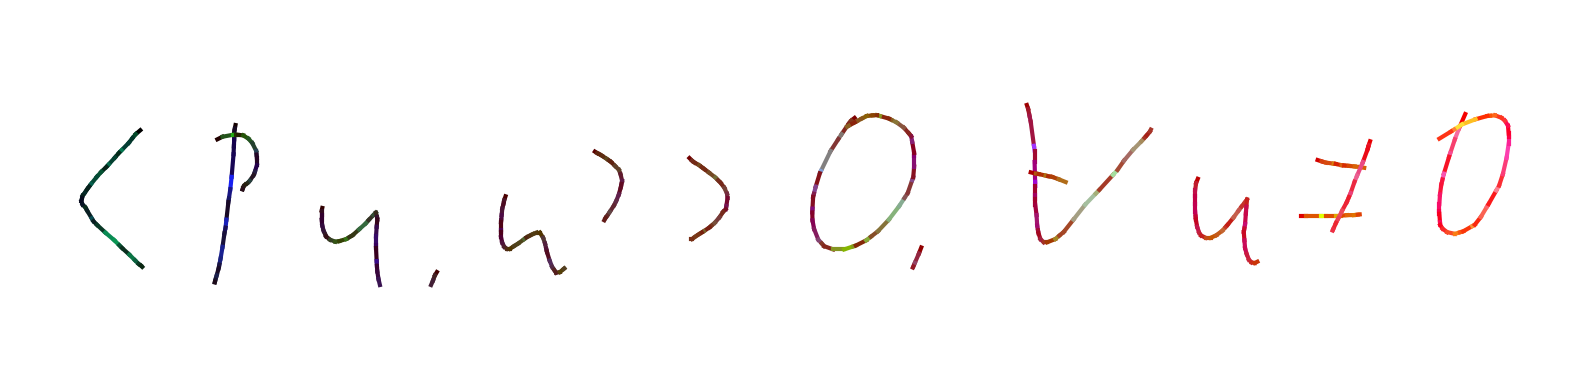

In [100]:
# TEST PURPOSE
test_inkml_file_path = data_dir / "mathwriting-2024-excerpt" / "train" / "0435a7e82431e973.inkml"
test_ink = read_inkml_file(test_inkml_file_path)
test_img_array = get_ink_image(test_ink)


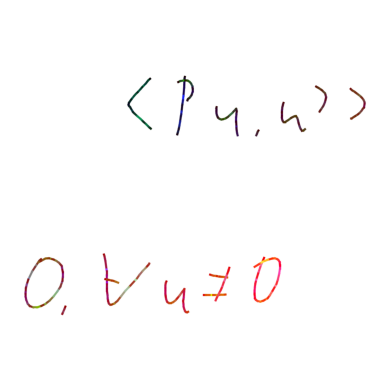

In [92]:
# TEST PURPOSE
plt.axis('off')
plt.imshow(test_img_array)
